# Study of apartment sales ads

We have at our disposal data from the Yandex.Real Estate service — a database of apartment sales ads in Saint Petersburg and neighboring towns for several years. The goal of the study is to determine the market value of real estate properties.  

For each apartment for sale, two types of data are available. The first type is entered by the user, and the second type is obtained automatically based on map data. For example, the distance to the city center, airport, nearest park, and body of water.

**Data description:**  
`airports_nearest` — distance to the nearest airport in meters (m)  
`balcony` — number of balconies  
`ceiling_height` — ceiling height in meters (m)  
`cityCenters_nearest` — distance to the city center in meters (m)  
`days_exposition` — how many days the ad was active (from publication to removal)  
`first_day_exposition` — publication date  
`floor` — floor number  
`floors_total` — total number of floors in the building  
`is_apartment` — whether it is an apartment (boolean type)  
`kitchen_area` — kitchen area in square meters (m²)  
`last_price` — price at the time of ad removal  
`living_area` — living area in square meters (m²)  
`locality_name` — name of the locality  
`open_plan` — open floor plan (boolean type)  
`parks_around3000` — number of parks within a 3 km radius  
`parks_nearest` — distance to the nearest park in meters (m)  
`ponds_around3000` — number of bodies of water within a 3 km radius  
`ponds_nearest` — distance to the nearest body of water in meters (m)  
`rooms` — number of rooms  
`studio` — studio apartment (boolean type)  
`total_area` — total area of the apartment in square meters (m²)  
`total_images` — number of photos of the apartment in the ad  

## Dataset Loading and General Information Analysis

In [7]:
import os
import numpy as np
from numpy import floor

import pandas as pd
import matplotlib.pyplot as plt

In [8]:
BASE_DIR = os.getcwd()
data = pd.read_csv(f'{BASE_DIR}\datasets\\real_estate_data.csv', sep='\t')
initial_data = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

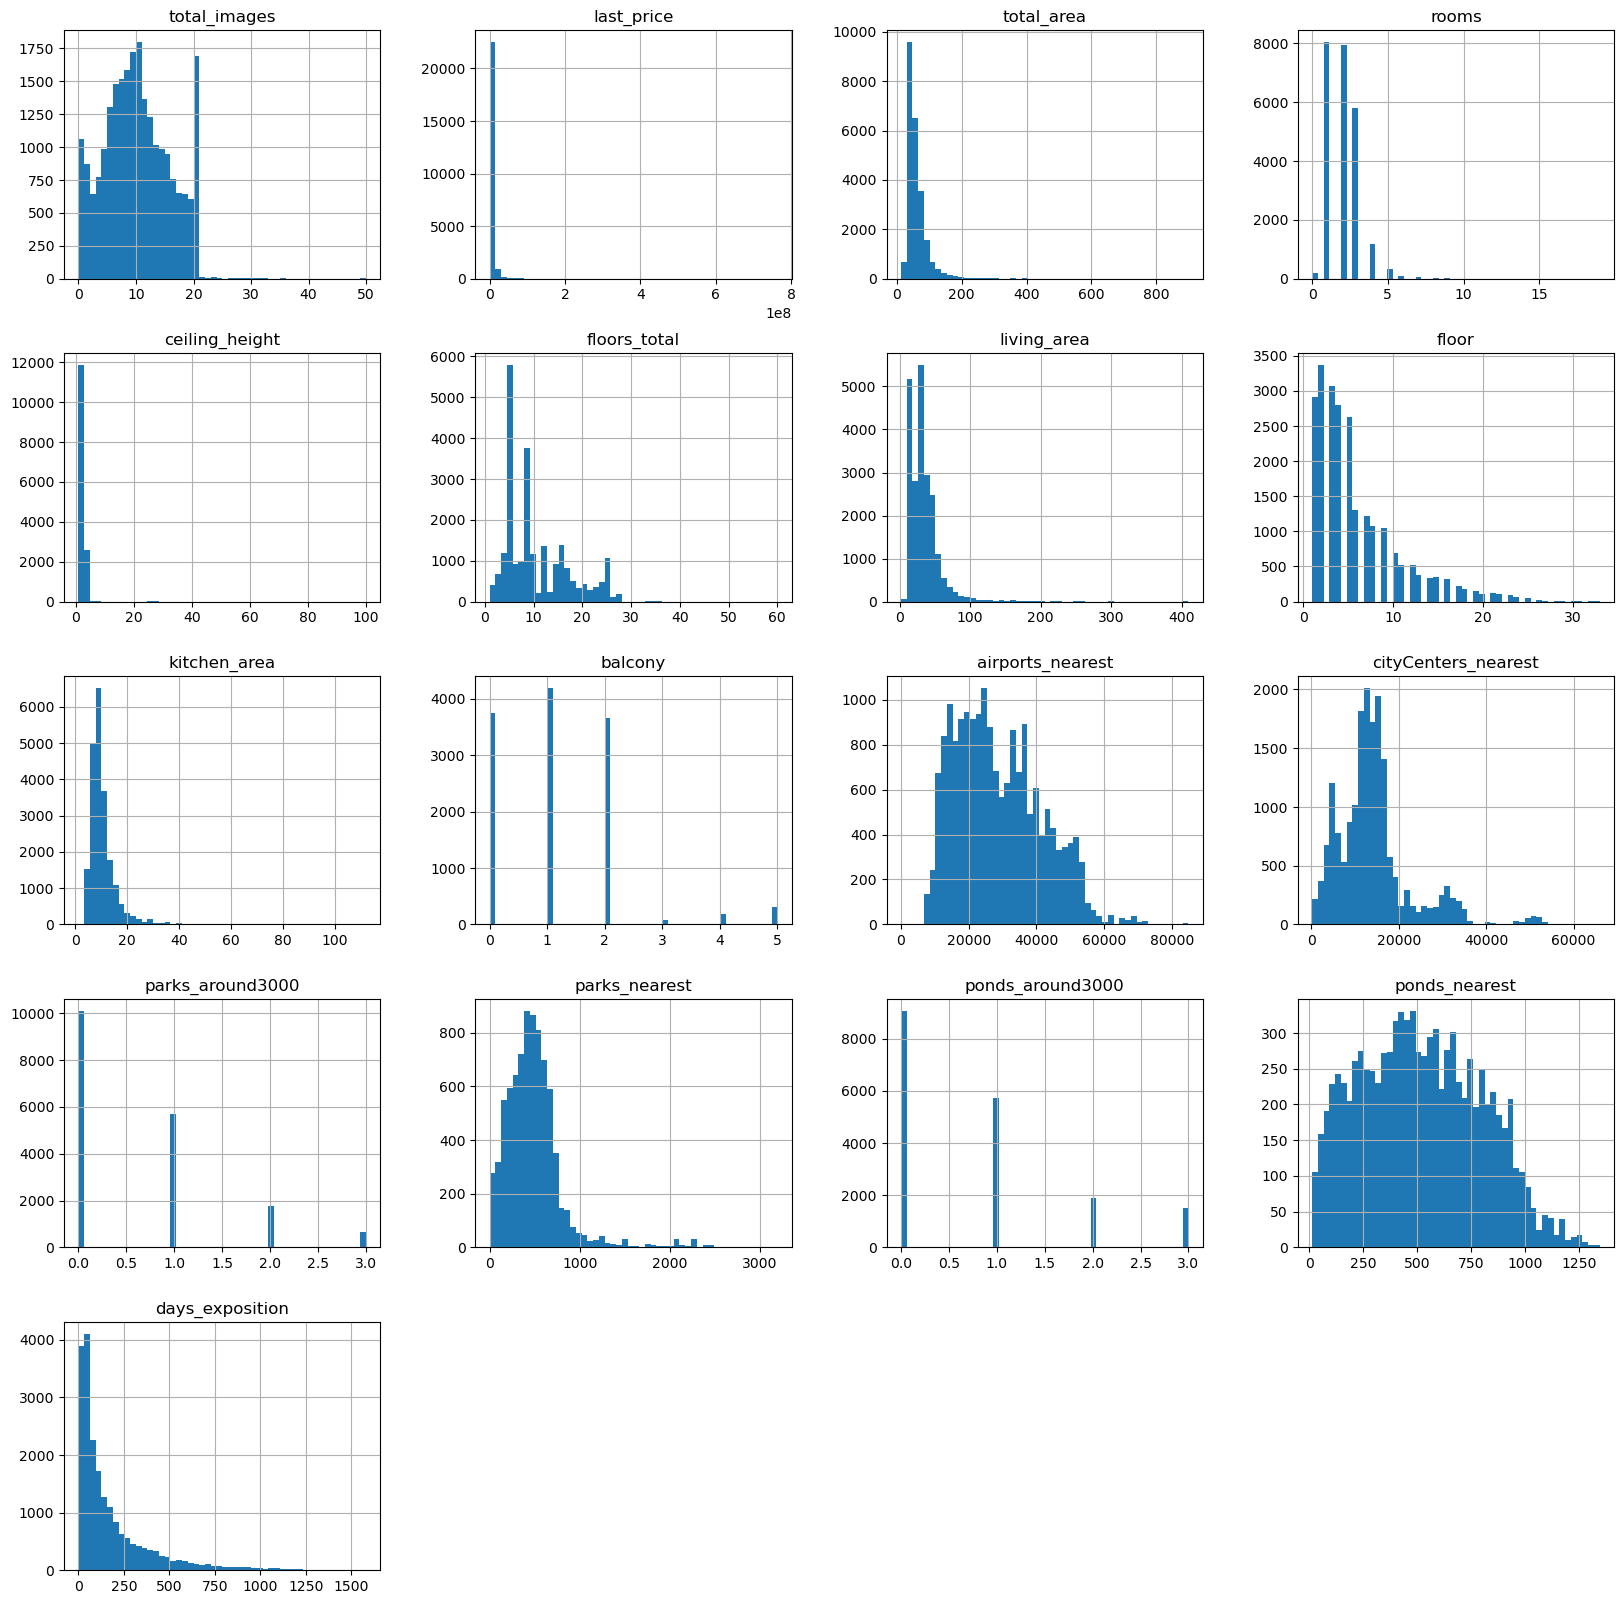

In [9]:
data.hist(bins=50, figsize=(20, 20));

In [10]:
pd.DataFrame(round(data.isna().mean()*100, 1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


In [11]:
[print(i) for i in sorted(data['locality_name'].astype(str).dropna().unique())];

69th Kilometer Platform settlement
Aleksandrovskaya village
Alexeyevka settlement
Annino village
Beloostrov settlement
Boksitogorsk
Bol'shaya Izhora urban settlement
Bolshaya Izhora urban-type settlement
Bolshaya Pustomerzha village
Bolshaya Vruda village
Bolshoy Sabsk village
Bolshoye Reizino village
Bor village
Borisova Griva village
Bugry urban-type settlement
Druzhnoselye settlement
Dzerzhinskogo settlement
Falileevo village
Fornosovo urban-type settlement
Fort Krasnaya Gorka settlement
Fyodorovskoye village
Garbolovo settlement
Gatchina
Gladkoe settlement
Glinka village
Goncharovo settlement
Gromovo railway station settlement
Gromovo settlement
Ivangorod
Kal'tino village
Kalitino settlement
Kalozhitsy village
Kamennogorsk
Kaskovo village
Kelozhi village
Kingisepp
Kingiseppsky settlement
Kipen village
Kirishi
Kirovsk
Kirpichnoe settlement
Kiselnia village
Kivennapa Sever cottage settlement
Kobralovo settlement
Kolpino
Kommunar
Kommunary settlement
Kondratyevo urban-type settlement


At first glance, the data appears to be natural, and no significantly outliers are visible in the graphs.  
The data column types require transformation.  
There are many missing values in the data, so we need to attempt to fill them in.  
We also need to check the data for obvious duplicates, specifically duplicates in the column with location names.

## Data Preprocessing

### Data Type Conversion

In [12]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT00:00:00')
data['floors_total'] = data['floors_total'].astype('Int64')
data['balcony'] = data['balcony'].astype('Int64')
data['ceiling_height'] = data['ceiling_height'].astype(float)
data['parks_around3000'] = data['parks_around3000'].astype('Int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('Int64')
data['days_exposition'] = floor(pd.to_numeric(data['days_exposition'], errors='coerce')).astype('Int64')

The data types of the columns are adjusted to match the data stored in them.

### Finding and Replacing Duplicates

It makes sense to search for duplicates only in the column with location names among all the columns with data.

In [13]:
locs = list(data['locality_name'].dropna().unique())

First, let's determine how many unique values we have initially.  

In [14]:
data['locality_name_initial'] = data['locality_name']
print(len(data['locality_name'].unique()))

350


There are 365 unique values in the list of localities.  
Let's see if the number of values decreases if we convert all values to the same case.

In [15]:
data['locality_name'] = data['locality_name'].str.lower()
print(len(data['locality_name'].unique()))

350


The number of unique values did not decrease. Let's try replacing 'ё' with 'е'.

In [16]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('Ё', 'Е')
print(len(data['locality_name'].unique()))

350


The number of unique values decreased by 34.  
Now let's try removing the names of locality types.

In [17]:
def mult_str_part_remove(dat, l):
    for s in l:
        dat = dat.str.replace(s, '')
    return dat

to_replace = [
    ' urban-type settlement',
    'urban-type settlement ',
    ' non-profit gardening association',
    ' gardening association',
    'settlement named after ',
    'urban settlement ',
    ' urban settlement',
    ' near the railway station',
    'urban-type settlement named after ',
    ' garden association',
    'settlement of ',
    'settlement ',
    ' settlement',
    ' village',
    'village ',
    'named after ',
    ' cottage',
]

data['locality_name'] = mult_str_part_remove(data['locality_name'], to_replace)

print(len(data['locality_name'].unique()))

data['locality_name'] = data['locality_name'].str.capitalize()
data['locality_name'] = data['locality_name'].mask(data['locality_name'] == 'Санкт-петербург', 'Санкт-Петербург')


318


The number of unique values decreased by another 25.  
In the end, we reduced the number of unique names from 365 to 306.

In [18]:
data.pivot_table(index='locality_name', values='locality_name_initial',aggfunc=('nunique', 'unique')).query('nunique > 1')

,nunique,unique
locality_name,,
Annino,2,"[Annino village, settlement Annino]"
Fornosovo,2,"[urban-type settlement Fornosovo, Fornosovo ur..."
Fyodorovskoye,2,"[Fyodorovskoye village, urban settlement Fyodo..."
Garbolovo,2,"[village Garbolovo, Garbolovo settlement]"
Gavrilovo,2,"[urban settlement Gavrilovo, settlement Gavril..."
Kalitino,2,"[village Kalitino, Kalitino settlement]"
Kudrovo,2,"[Kudrovo village, Kudrovo]"
Lebyazhye,2,"[Lebyazhye urban-type settlement, urban-type s..."
Lesnoe,2,"[Lesnoe settlement, Lesnoe cottage settlement]"


### Filling in Missing Values and Handling Anomalous Data

In [19]:
print('Total number of rows:', data.iloc[:, 0].count(), end='\n\n')
print('Number of missing values in columns:')
print(data.isna().sum())

Total number of rows: 23699

Number of missing values in columns:
total_images                 0
last_price                   0
total_area                   0
first_day_exposition         0
rooms                        0
ceiling_height            9195
floors_total                86
living_area               1903
floor                        0
is_apartment             20924
studio                       0
open_plan                    0
kitchen_area              2278
balcony                  11519
locality_name               49
airports_nearest          5542
cityCenters_nearest       5519
parks_around3000          5518
parks_nearest            15620
ponds_around3000          5518
ponds_nearest            14589
days_exposition           3181
locality_name_initial       49
dtype: int64


In [20]:
print('The following columns have missing data:')
[print(x) for x in list(data.columns[data.isna().sum() > 0])];

The following columns have missing data:
ceiling_height
floors_total
living_area
is_apartment
kitchen_area
balcony
locality_name
airports_nearest
cityCenters_nearest
parks_around3000
parks_nearest
ponds_around3000
ponds_nearest
days_exposition
locality_name_initial


#### Filling in the Missing Values in the 'rooms' Column

In [21]:
data.query('rooms == 0')['rooms'].count()

197

There are 197 zero values in the 'rooms' column, which contradicts the nature of the feature since a room cannot have 0 rooms. Let's replace the zero values with ones.

In [22]:
data['rooms'] = data['rooms'].mask(data['rooms'] == 0, 1)

#### Filling in the Missing Values in the 'cityCenters_nearest' Column

First, let's rename the column.

In [23]:
data = data.rename(columns={'cityCenters_nearest': 'city_center_nearest'})

In [24]:
city_centers_na = data['city_center_nearest'].isna().sum()
city_centers = data['city_center_nearest'].count()
center_distance_spb = len(data[(data['city_center_nearest'].isna()) & (
    data['locality_name'] == 'Saint Petersburg')]['city_center_nearest'])
center_distance_not_spb = len(data[(data['city_center_nearest'].isna()) & (
    data['locality_name'] != 'Saint Petersburg')]['city_center_nearest'])
not_center_distance_spb = len(data[~(data['city_center_nearest'].isna()) & (
    data['locality_name'] == 'Saint Petersburg')]['city_center_nearest'])
not_center_distance_not_spb = len(data[~(data['city_center_nearest'].isna()) & (
    data['locality_name'] != 'Saint Petersburg')]['city_center_nearest'])

print(f'If the distance to the center is known and the city is St. Petersburg - {not_center_distance_spb} values out of {city_centers}.')
print(f'If the distance to the center is known and the city is not St. Petersburg - {not_center_distance_not_spb} values out of {city_centers}.')
print(f'If the distance to the center is unknown and the city is St. Petersburg - {center_distance_spb} missing values out of {city_centers_na}.')
print(f'If the distance to the center is unknown and the city is not St. Petersburg - {center_distance_not_spb} missing values out of {city_centers_na}.')


If the distance to the center is known and the city is St. Petersburg - 0 values out of 18180.
If the distance to the center is known and the city is not St. Petersburg - 18180 values out of 18180.
If the distance to the center is unknown and the city is St. Petersburg - 0 missing values out of 5519.
If the distance to the center is unknown and the city is not St. Petersburg - 5519 missing values out of 5519.


Most of the missing values for the distance to the city center are in L.O., and there are only 61 missing values in St. Petersburg.  
When filling in the missing values, we can rely on the data of objects located in the same localities.  
We will fill in the missing values based on the location of the object, according to the name of the locality.  

In [25]:
data.groupby('locality_name')['city_center_nearest'].median().count()

28

Before filling missing values: 5519
After filling missing values: 5519


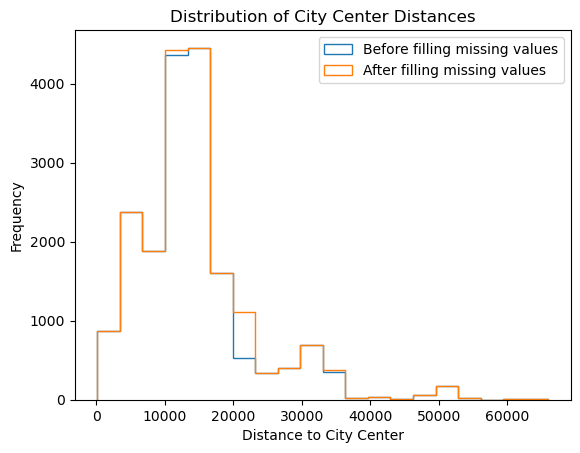

In [26]:
median_dist_lo = data.query('locality_name != "Saint Petersburg"')['city_center_nearest'].mean()

plt.hist(data['city_center_nearest'].dropna(), bins=20, histtype='step', label='Before filling missing values')
plt.hist(data['city_center_nearest'].fillna((data.groupby('locality_name')['city_center_nearest'].transform('median'))), bins=20, histtype='step', label='After filling missing values')
plt.legend()
plt.title('Distribution of City Center Distances')
plt.xlabel('Distance to City Center')
plt.ylabel('Frequency')

print('Before filling missing values:', data['city_center_nearest'].isna().sum())
print('After filling missing values:', data['city_center_nearest'].isna().sum())

As we can see, the histogram has changed only slightly, indicating that we did not distort the original data.  
However, if we continue to fill in the remaining missing values with the median for L.O., the changes will be too significant.  
We leave the remaining missing values as they are.  

#### Filling in the Missing Values in the 'ceiling_height' Column

In [27]:
print(data['ceiling_height'].describe())
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 20, data['ceiling_height']/10)
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] <= 6, None)
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] > 2, None)

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


A very large number of missing values and unrealistic ceiling height values were found:
- Values above 20 meters were interpreted as entries in incorrect units of measurement, for example, instead of 2.5 meters, it was recorded as 25. The reason may be that the data could be collected in mm or cm, and when rounded to meters, data originally recorded in mm will be 10 times larger than the actual values. It is unlikely that the seller intended to indicate a ceiling height less than 2 meters, so the threshold value is set at 20 meters. Values above 20 meters were divided by 10;
- Values from 6 meters to 20 meters were discarded as errors since a height of 6 meters is possible in some parts of living spaces (e.g., double-height spaces), but heights greater than 6 meters are unlikely. Values from 6 to 20 were replaced with the median;
- Values less than 2 meters will be considered incorrect, discarded, and replaced.  
  
With such a large number of missing values, it is not possible to simply replace all the data with the median.  
Let's assume that the ceiling height depends on the year of construction, with heights increasing closer to the historical center.  
Let's test this assumption.

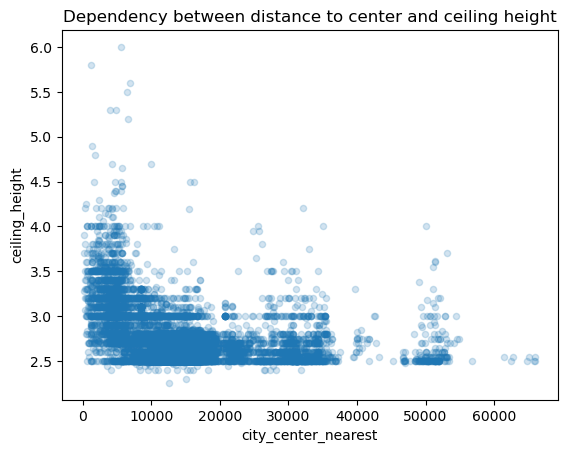

In [28]:
data.plot(x='city_center_nearest', y='ceiling_height', kind='scatter', alpha=0.2, title="Dependency between distance to center and ceiling height");

Indeed, there is a correlation between these two parameters: the closer to the center, the higher the ceilings.  
Let's fill in the missing values in the data according to this pattern.

In [29]:
data['ceiling_height'] = data['ceiling_height'].astype(float)
data['temp_chuncks'] = pd.qcut(data['city_center_nearest'], 10)
print(data.groupby('temp_chuncks')['ceiling_height'].median())

temp_chuncks
(180.999, 4766.0]     3.10
(4766.0, 7756.0]      3.00
(7756.0, 10493.5]     2.70
(10493.5, 11908.8]    2.60
(11908.8, 13098.5]    2.60
(13098.5, 14450.0]    2.64
(14450.0, 15616.6]    2.60
(15616.6, 17256.0]    2.60
(17256.0, 25955.8]    2.64
(25955.8, 65968.0]    2.60
Name: ceiling_height, dtype: float64


We divided the data based on the dependency of ceiling height into 10 slices and obtained the median value for each slice.  
It can be seen that closer to the center, the average height is 3.10m, while beyond 10km from the center, it hardly exceeds 2.6m.  
For objects where we have data on the distance to the center, let's replace the missing values with the obtained values.

In [30]:
print('Number of missing values before replacing with medians by distance:', data['ceiling_height'].isna().sum())
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby('temp_chuncks')['ceiling_height'].transform('median'))
print('Number of missing values after replacing with medians by distance:', data['ceiling_height'].isna().sum())
data = data.drop(columns=['temp_chuncks'], axis=1)

Number of missing values before replacing with medians by distance: 9217
Number of missing values after replacing with medians by distance: 2585


The number of missing values has significantly decreased, but there are still 2174 remaining.  
We can fill them with the median value for L.O., since there are no missing values left in St. Petersburg. Such replacement would be logical, but we won't fill in the remaining missing values due to the desire not to distort the original data too much.

#### Filling in the Missing Values in the 'floors_total' Column

Minimum number of floors in a building: 1
Maximum number of floors in a building: 60
Median number of floors in buildings: 9


Text(0, 0.5, 'Frequency')

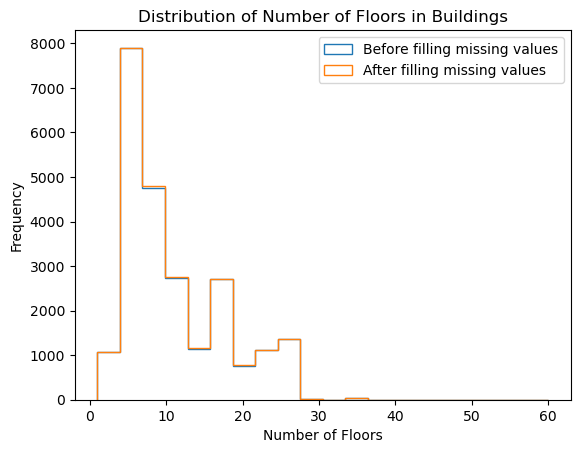

In [31]:
print('Minimum number of floors in a building:', data['floors_total'].sort_values().dropna().min())
print('Maximum number of floors in a building:', data['floors_total'].sort_values().dropna().max())
floors_total_median = int(data['floors_total'].median())
print('Median number of floors in buildings:', floors_total_median)

ax = data['floors_total'].plot(kind='hist', bins=20, histtype='step', label='Before filling missing values')
data['floors_total'] = data['floors_total'].fillna(floors_total_median)
data['floors_total'] = data['floors_total'].mask(data['floors_total'] < data['floor'], data['floor'])
data['floors_total'].plot(kind='hist', bins=20, ax=ax, histtype='step', label='After filling missing values')

plt.legend()
plt.title('Distribution of Number of Floors in Buildings')
plt.xlabel('Number of Floors')
plt.ylabel('Frequency')

The values look realistic, as 9-story buildings are among the most common in Russia. The missing values are filled with the median.  
After filling in the missing values, the histogram changed slightly.

#### Filling in the Missing Values in the 'living_area' Column

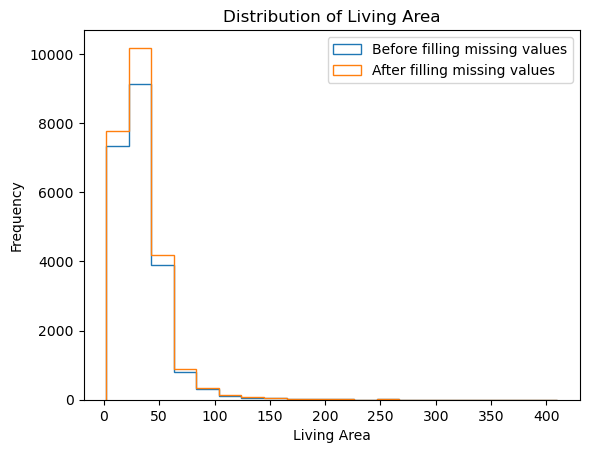

In [32]:
ax = data['living_area'].plot(kind='hist', bins=20, histtype='step', label='Before filling missing values')

data['temp_chuncks_2'] = pd.qcut(data['last_price'], 20)
data['temp_val'] = data['living_area'] / data['total_area']
data['living_area'] = data['living_area'].fillna(data.groupby('temp_chuncks_2')['temp_val'].transform('median') * data['total_area'])

data['living_area'].plot(kind='hist', bins=20, ax=ax, histtype='step', label='After filling missing values')

data = data.drop(columns=['temp_chuncks_2', 'temp_val'], axis=1)

plt.legend()
plt.title('Distribution of Living Area')
plt.xlabel('Living Area')
plt.ylabel('Frequency')

plt.show()

The values ranging from 2 to 409.7 sq.m. of living area look realistic.  
The missing values are filled with the median share of living area relative to the total area of the property, based on the price category.  
From the change in the histogram, it can be seen that the data is not significantly distorted.

#### Filling in the Missing Values in the 'is_apartment' Column

In [33]:
data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)

The type of apartments is not very popular in Russia, so if the seller did not indicate it, it is likely that the property is not an apartment.  
The missing values are filled with the value 'False'.

#### Filling in the Missing Values in the 'kitchen_area' Column

In [34]:
print(data['kitchen_area'].sort_values().dropna())

20217      1.3
9138       2.0
6262       2.0
21419      2.0
19642      2.0
         ...  
16239     93.2
5358     100.0
2489     100.7
20215    107.0
19540    112.0
Name: kitchen_area, Length: 21421, dtype: float64


There is a property with a kitchen area of over 100 sq.m.

In [35]:
data.iloc[19540, :]

total_images                               8
last_price                       420000000.0
total_area                             900.0
first_day_exposition     2017-12-06 00:00:00
rooms                                     12
ceiling_height                           2.8
floors_total                              25
living_area                            409.7
floor                                     25
is_apartment                           False
studio                                 False
open_plan                              False
kitchen_area                           112.0
balcony                                 <NA>
locality_name               Saint petersburg
airports_nearest                     30706.0
city_center_nearest                   7877.0
parks_around3000                           0
parks_nearest                            NaN
ponds_around3000                           2
ponds_nearest                          318.0
days_exposition                          106
locality_n

With a total area of 900 sq.m., it is likely that there are no errors in the data.  

There are many zero values in the data. First, we need to determine the interpretation of such anomalies. Zero values can indicate errors or apartments without kitchens. Since a significant share of the market in St. Petersburg is occupied by communal apartments, the missing values in the data can indeed mean the absence of a kitchen. To find out, let's compare the data on the areas of all apartments and apartments with missing values in the kitchen column.

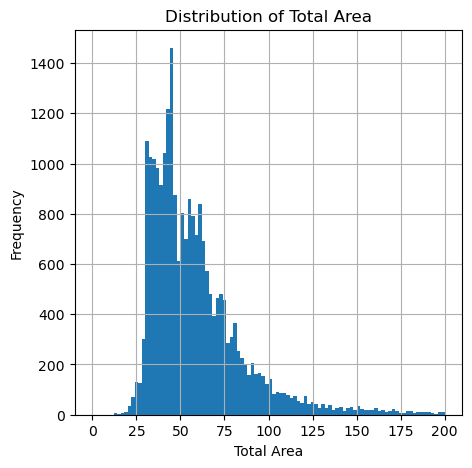

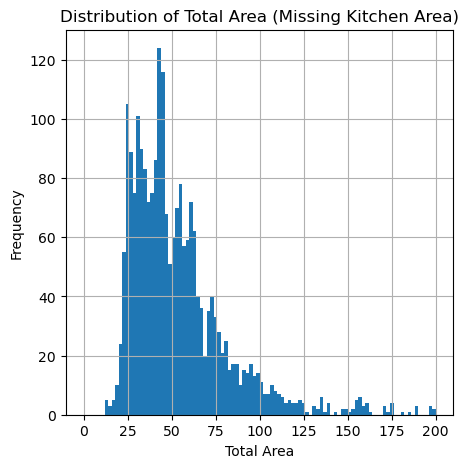

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64
count    2278.000000
mean       56.575680
std        40.863558
min        12.000000
25%        34.000000
50%        46.000000
75%        64.725000
max       500.000000
Name: total_area, dtype: float64


In [36]:
data_temp = data.copy()

plt.figure(figsize=(8, 6))
data['total_area'].hist(bins=100, figsize=(5, 5), range=(0, 200))
plt.xlabel('Total Area')
plt.ylabel('Frequency')
plt.title('Distribution of Total Area')
plt.show()

plt.figure(figsize=(8, 6))
data[data['kitchen_area'].isna()]['total_area'].hist(bins=100,  figsize=(5, 5), range=(0, 200))
plt.xlabel('Total Area')
plt.ylabel('Frequency')
plt.title('Distribution of Total Area (Missing Kitchen Area)')
plt.show()

print(data['total_area'].describe())
print(data[data['kitchen_area'].isna()]['total_area'].describe())

If we plot the histogram of all apartment areas and the histogram of apartment areas where the data on kitchens is missing, we can see that the latter graph is slightly shifted to the left.  
It is likely that some of these apartments indeed have no kitchens, while in some cases, the values are missing. We need to distinguish between these cases since the missing values account for about 10%, and we cannot uniformly replace the data in order not to distort the values too much.  
We have data on whether the apartment is a studio, let's check it.

In [37]:
print(data['kitchen_area'].isna().sum())
print(data['studio'].sum())
print(data[(data['kitchen_area'].isna()) & (data['studio'] == True)]['studio'].sum())
data.loc[data['studio'] == True, 'kitchen_area'] = data.loc[data['studio'] == True, 'kitchen_area'].fillna(0)

2278
149
149


Out of 2278 apartments without kitchens, 149 are studios. We will replace the data in these cases with 0 since studios have kitchens, but their area cannot be determined.

We can assume that apartments without kitchens and with an area smaller than a studio are communal apartments. For apartments with an area larger than the average studio area, it is likely that the values are missing.

In [38]:
median_studio_total_area = data.query('studio == True')['total_area'].median()
print('Median total area of studio apartments:', median_studio_total_area)
print('Number of apartments without kitchens:', data.query('total_area < @median_studio_total_area and kitchen_area.isna()')['total_area'].count())
print('Number of apartments with missing values:', data.query('total_area > @median_studio_total_area')['total_area'].count())

Median total area of studio apartments: 26.0
Number of apartments without kitchens: 142
Number of apartments with missing values: 23400


For apartments that we consider communal, we will leave the missing values as they are.  
For apartments with an area larger than the average studio area, we fill in the missing values with the median value of the kitchen area to the total area ratio.

In [39]:
data['temp_chuncks_3'] = pd.qcut(data['total_area'], 20)
data['temp_kitchen_multiplyer'] = data['kitchen_area']/data['total_area']
data.loc[data['total_area'] > median_studio_total_area, 'kitchen_area'] = data['kitchen_area'].fillna(data.groupby('temp_chuncks_3')['temp_kitchen_multiplyer'].transform('median')*data['total_area'])
data = data.drop(columns=['temp_chuncks_3', 'temp_kitchen_multiplyer'], axis=1)

Let's check how the histogram has changed.

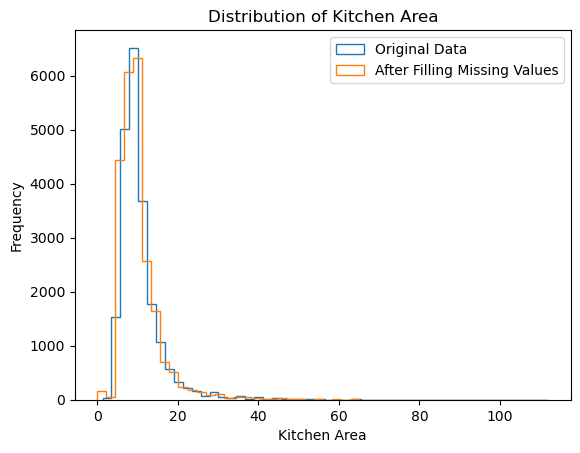

In [40]:
ax = data_temp['kitchen_area'].plot(kind='hist', bins=50, histtype='step', label='Original Data')
data['kitchen_area'].plot(kind='hist', bins=50, ax=ax, histtype='step', label='After Filling Missing Values')
plt.xlabel('Kitchen Area')
plt.ylabel('Frequency')
plt.title('Distribution of Kitchen Area')
plt.legend()
plt.show()

The missing values are filled, and the data is not distorted.

#### Filling in the Missing Values in the 'balcony' Column

In [41]:
data['balcony'] = data['balcony'].fillna(0)

If the data on the number of balconies is missing, it is likely that there are no balconies in the apartment.  
The missing values are filled with a value of 0.

#### Filling in the Missing Values in the 'locality_name' Column

The locality name will remain unknown since it is not possible to restore the data.

#### Filling in the Missing Values in the 'airports_nearest' Column

Let's see how the location of the property relates to the distance to the airport.

In [42]:
city_centers_na = data['airports_nearest'].isna().sum()
city_centers = data['airports_nearest'].count()
center_distance_spb = len(data[(data['airports_nearest'].isna()) & (
    data['locality_name'] == 'Saint Petersburg')]['airports_nearest'])
center_distance_not_spb = len(data[(data['airports_nearest'].isna()) & (
    data['locality_name'] != 'Saint Petersburg')]['airports_nearest'])
not_center_distance_spb = len(data[~(data['airports_nearest'].isna()) & (
    data['locality_name'] == 'Санкт-Петербург')]['airports_nearest'])
not_center_distance_not_spb = len(data[~(data['airports_nearest'].isna()) & (
    data['locality_name'] != 'Санкт-Петербург')]['airports_nearest'])

print(f'If the distance to the airport is known and the city is Saint Petersburg - {not_center_distance_spb} values out of {city_centers}.')
print(f'If the distance to the airport is known and the city is not Saint Petersburg - {not_center_distance_not_spb} values out of {city_centers}.')
print(f'If the distance to the airport is unknown and the city is Saint Petersburg - {center_distance_spb} missing values out of {city_centers_na}.')
print(f'If the distance to the airport is unknown and the city is not Saint Petersburg - {center_distance_not_spb} missing values out of {city_centers_na}.')

If the distance to the airport is known and the city is Saint Petersburg - 0 values out of 18157.
If the distance to the airport is known and the city is not Saint Petersburg - 18157 values out of 18157.
If the distance to the airport is unknown and the city is Saint Petersburg - 0 missing values out of 5542.
If the distance to the airport is unknown and the city is not Saint Petersburg - 5542 missing values out of 5542.


The missing values for the distance to the airport are mainly found in L.O., with only 85 missing values in St. Petersburg.  
When filling in the missing values, we can rely on the data of objects located in the same localities.  
Let's fill in the missing values according to the location of the property, based on the name of the locality.  

In [43]:
data.groupby('locality_name')['airports_nearest'].median().count()

28

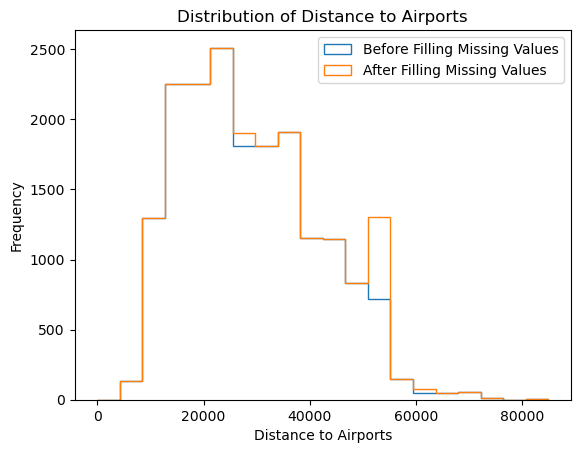

In [44]:
ax = data['airports_nearest'].plot(kind='hist', bins=20, histtype='step', label='Before Filling Missing Values')
median_dist_lo = data.query('locality_name != "Saint Petersburg"')['airports_nearest'].mean()

data['airports_nearest'] = data['airports_nearest'].fillna((data.groupby('locality_name')['airports_nearest'].transform('median')))
data['airports_nearest'].plot(kind='hist', bins=20, ax=ax, histtype='step', label='After Filling Missing Values')
plt.xlabel('Distance to Airports')
plt.ylabel('Frequency')
plt.title('Distribution of Distance to Airports')
plt.legend()
plt.show()

As we can see, the histogram has changed slightly, indicating that we have slightly distorted the original data.  
However, if we continue to fill in the missing values with the median for L.O., the changes would be too significant.  
We won't fill in the remaining missing values since it is not possible to determine the distance to the airport.

#### Filling in the Missing Values in the Columns: 'parks_nearest', 'parks_around3000', 'ponds_nearest', 'ponds_around3000'

In [45]:
print(data[(data['parks_nearest'] > 3000) & (data['parks_around3000'] > 0)]['parks_nearest'].count())
print(data[(data['ponds_nearest'] > 3000) & (data['ponds_around3000'] > 0)]['ponds_nearest'].count())

data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

0
0


'parks_around3000' indicates the number of parks within a 3000m radius:
- if parks > 0, the nearest park is indicated in 'parks_nearest';
- if <=0, the field remains empty.  

At the same time, some values in 'parks_around3000' are filled with 0, while others are NaN. It makes sense to fill in the missing values with zeros to avoid confusion.
NaN values in the 'parks_nearest' column remain unchanged.

The same applies to the data on ponds.

#### Filling in the Missing Values in the 'days_expositions' Column

The missing values in 'days_expositions' should remain as missing values since the listings are still active.

**Let's double-check the result of preprocessing:**

In [46]:
initial_data.info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [47]:
print(initial_data.isna().sum())
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64
total_images                 0
last_price                   0
total_area                   0
first_day_exposition         0
rooms                        0
ceiling_height            2585
floors_total                 0
living_area                  0
floor                        0
is_apartment                 0
studio           

As a result of the work performed, the data types have been aligned with the data in the columns.

The number of duplicates in the location names has been reduced.

The missing values have been filled in the following columns:
- building floors;
- living area;
- whether the property is an apartment;
- presence of balconies;
- presence of parks and ponds within a 3000-meter radius.

The number of missing values has been reduced in the following columns:
- ceiling height;
- kitchen area;
- distance to the airport;
- distance to the city center.

## Adding New Features

Based on the available data, we can add new features.

In [48]:
data['sq_m_price'] = (data['last_price']/data['total_area']).round(2)

data['publish_weekday'] = data['first_day_exposition'].dt.weekday

data['publish_month'] = data['first_day_exposition'].dt.month

data['publish_year'] = data['first_day_exposition'].dt.year


def floor_and_floors(ap_floor, bld_floor):
    ap_floor = list(ap_floor)
    bld_floor = list(bld_floor)
    result = []
    for i in range(len(ap_floor)):
        if ap_floor[i] == 1:
            result.append('first')
        elif ap_floor[i] == bld_floor[i]:
            result.append('last')
        else:
            result.append('other')
    return result

data['floor_type'] = (floor_and_floors(data['floor'], data['floors_total']))

data['city_center_nearest_km'] = (data['city_center_nearest']/1000).round().astype('Int64')

The following columns have been added to the table:
- column with price per square meter;
- column with the day of the week when the ad was published (0 - Monday, 1 - Tuesday, etc.);
- column with the month when the ad was published;
- column with the year when the ad was published;
- column with the floor type of the apartment (values: 'first', 'last', 'other');
- column with the distance to the city center in kilometers.

## Exploratory Data Analysis

### Number of Rooms

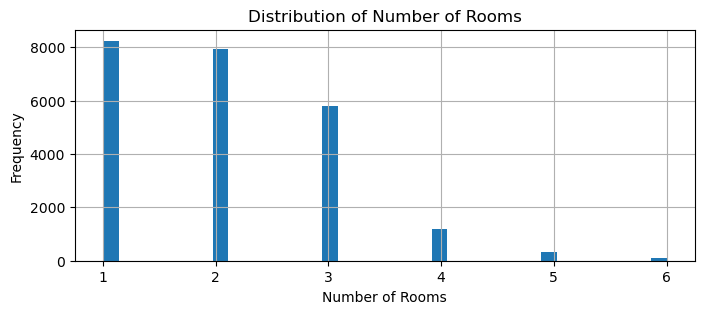

In [49]:
data['rooms'].hist(bins=36, figsize=(8, 3), range=(1, 6))
plt.xlabel('Number of Rooms')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Rooms')
plt.show()

One-room apartments are the most common, followed closely by two-room apartments, then three-room apartments, and so on.

### Living Area

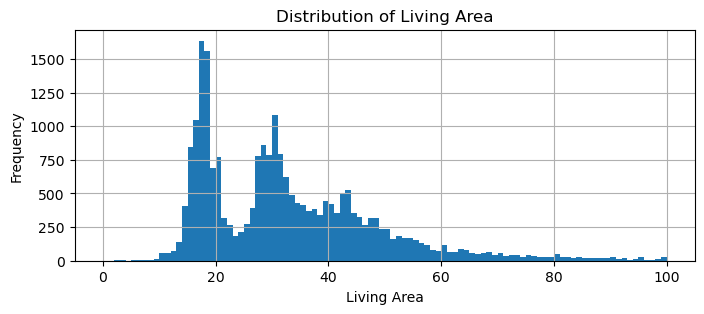

In [50]:
data['living_area'].hist(bins=100, figsize=(8, 3), range=(0, 100))
plt.xlabel('Living Area')
plt.ylabel('Frequency')
plt.title('Distribution of Living Area')
plt.show()

At first glance, the data appears to consist of several overlapping histograms with a distribution close to normal. This may be due to the number of rooms in the apartments. Let's test this assumption.

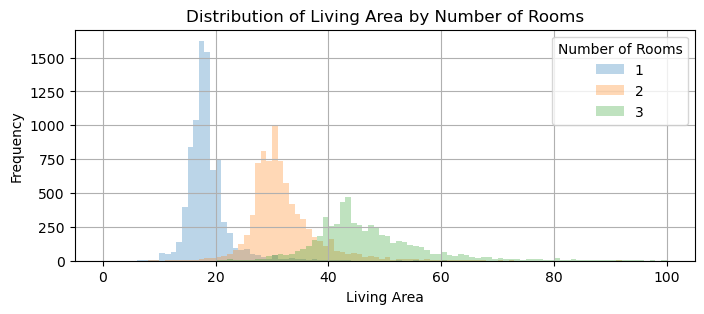

In [51]:
fig, ax = plt.subplots()
for col in [1, 2, 3]:
    data.query('rooms == @col')['living_area'].hist(bins=100, figsize=(8, 3), range=(0, 100), alpha=0.3, ax=ax, label=col)
plt.xlabel('Living Area')
plt.ylabel('Frequency')
plt.title('Distribution of Living Area by Number of Rooms')
plt.legend(title='Number of Rooms')
plt.show()

The assumption has been confirmed. Indeed, the data is fine, and the three peaks represent the three types of apartments based on the number of rooms.

### Total Area

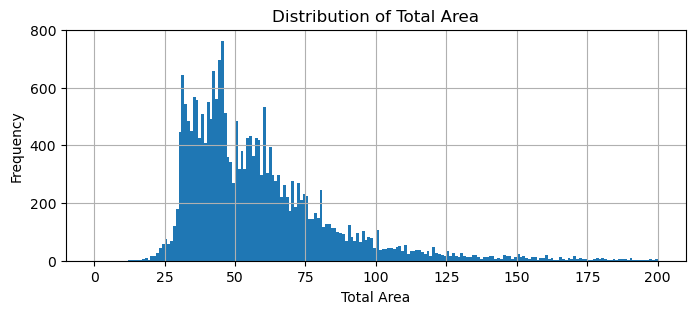

In [52]:
data['total_area'].hist(bins=200, figsize=(8, 3), range=(0, 200))
plt.xlabel('Total Area')
plt.ylabel('Frequency')
plt.title('Distribution of Total Area')
plt.show()

The distribution of apartment areas resembles a Poisson curve with a sawtooth edge. It is logical to assume that this shape has the same nature as in the case of the living area.
Overall, the data looks natural, and both 12 and 900 square meters are realistic sizes for residential properties.

### Kitchen Area

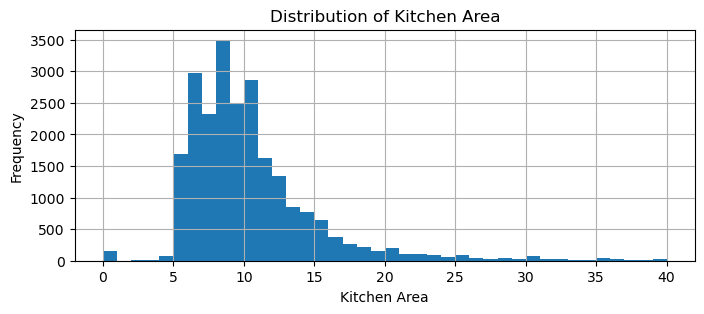

In [53]:
data['kitchen_area'].hist(bins=40, figsize=(8, 3), range=(0, 40))
plt.xlabel('Kitchen Area')
plt.ylabel('Frequency')
plt.title('Distribution of Kitchen Area')
plt.show()

The most common kitchen size is 9 square meters.
Zero values were assigned to studio apartments.
The maximum area is 112 square meters.

### Property Price

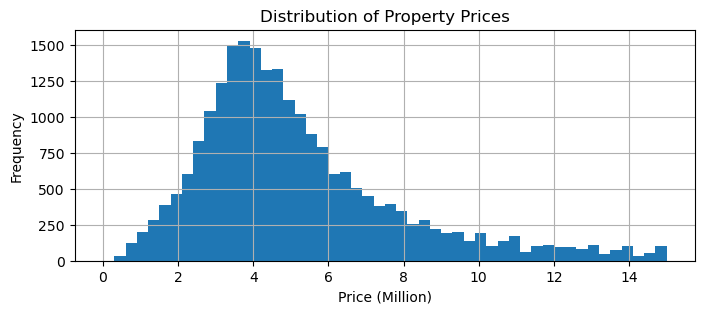

In [54]:
(data['last_price']/1000000).hist(bins=50, figsize=(8, 3), range=(0, 15))
plt.xlabel('Price (Million)')
plt.ylabel('Frequency')
plt.title('Distribution of Property Prices')
plt.show()

Prices vary over a wide range, with the most common deals falling between 3.4 and 6.8 million rubles.

### Ceiling Height

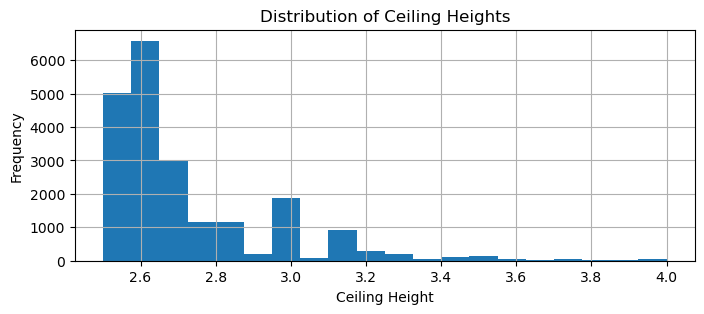

In [55]:
data['ceiling_height'].hist(bins=20, figsize=(8, 3), range=(2.5, 4))
plt.xlabel('Ceiling Height')
plt.ylabel('Frequency')
plt.title('Distribution of Ceiling Heights')
plt.show()

The most common ceiling height is 2.6 meters.
Ceiling heights vary depending on the year of construction and, as a result, the distance from the historical city center.
Within a five-kilometer radius of the city center, the median ceiling height is 3.1 meters.

### Apartment Floor

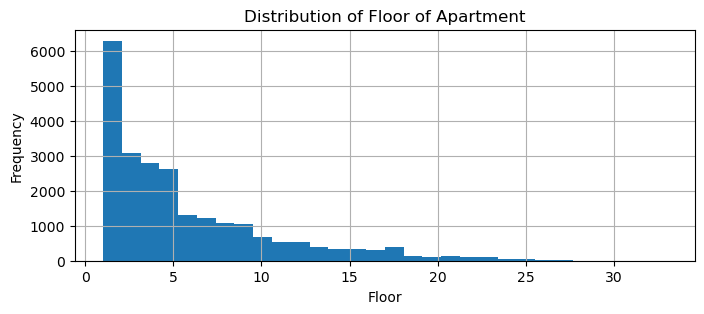

In [56]:
data['floor'].hist(bins=30, figsize=(8, 3))
plt.xlabel('Floor')
plt.ylabel('Frequency')
plt.title('Distribution of Floor of Apartment')
plt.show()

Most apartments are located on the first floor. Every building has a first floor, while the second and subsequent floors are less common.

### Floor Type

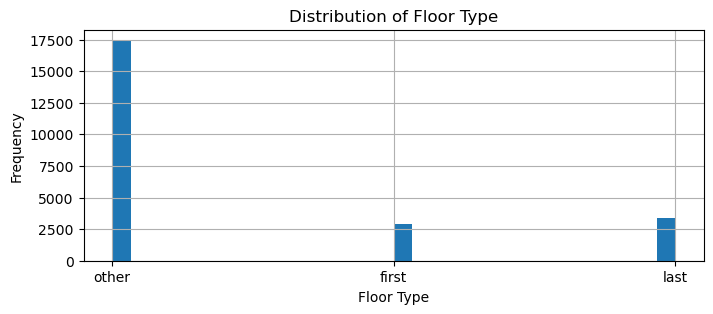

In [57]:
data['floor_type'].hist(bins=30, figsize=(8, 3))
plt.xlabel('Floor Type')
plt.ylabel('Frequency')
plt.title('Distribution of Floor Type')
plt.show()

If we compare the frequency of apartments on the first and last floors, we will find that apartments on the first floor are less frequently listed. This is because built-in premises are often located on the first floors, especially in new buildings, which is due to changes in regulatory documents in housing construction.

### Total Number of Floors in the Building

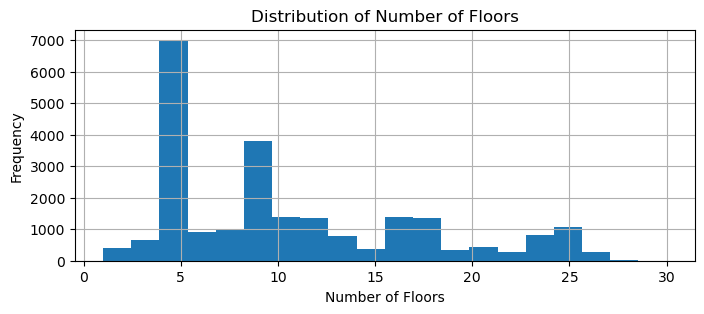

In [58]:
data['floors_total'].hist(bins=20, figsize=(8, 3), range=(1, 30))
plt.xlabel('Number of Floors')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Floors')
plt.show()

Four- and five-story buildings are the most common, followed by nine-story buildings. There are also peaks at 17-18 floors and 25 floors.
All of these peaks are related to regulations in housing construction, such as the number of elevators, accessibility of the upper floors via fire escape stairs, the presence of a fire helicopter in the city, and so on.

### Distance to City Center in Meters

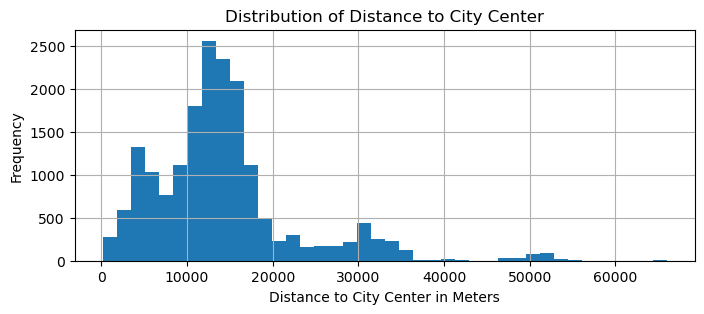

In [59]:
data['city_center_nearest'].hist(bins=40, figsize=(8, 3))
plt.xlabel('Distance to City Center in Meters')
plt.ylabel('Frequency')
plt.title('Distribution of Distance to City Center')
plt.show()

The largest number of properties are located in the range of 9-17 km. Overall, the graph appears somewhat uneven, which can be attributed to variations in urban development, industrial zones, terrain features, and so on.

### Distance to Nearest Airport

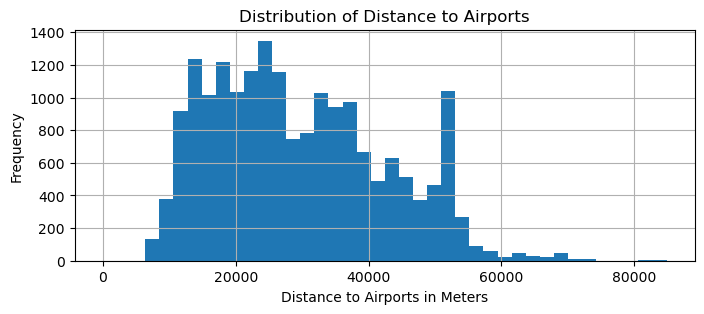

In [60]:
data['airports_nearest'].hist(bins=40, figsize=(8, 3))
plt.xlabel('Distance to Airports in Meters')
plt.ylabel('Frequency')
plt.title('Distribution of Distance to Airports')
plt.show()

Similar to the histogram of distances to the city center, the graph appears uneven. However, it can be clearly seen that the majority of properties are located within a range of 19-38 km.

### Distance to Nearest Park

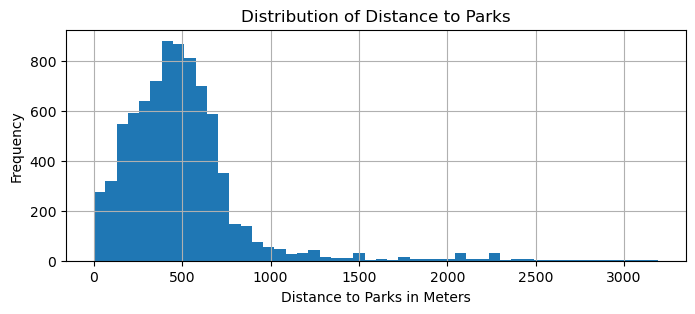

In [61]:
data['parks_nearest'].hist(bins=50, figsize=(8, 3))
plt.xlabel('Distance to Parks in Meters')
plt.ylabel('Frequency')
plt.title('Distribution of Distance to Parks')
plt.show()

In this column, we left many missing values because only parks within a distance of less than 3000 meters were considered.
However, the histogram shows that the majority of properties are located within 300-600 meters from a park, while parks at a distance of more than one and a half kilometers are extremely rare. This indicates that the park system in St. Petersburg is efficiently designed.

### Day and Month of Ad Publication

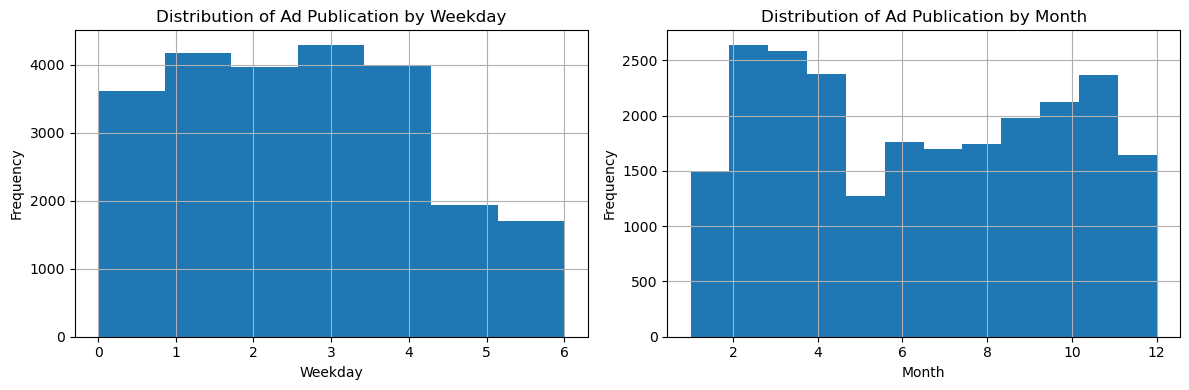

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

data['publish_weekday'].hist(bins=7, ax=axes[0])
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Ad Publication by Weekday')

data['publish_month'].hist(bins=12, ax=axes[1])
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Ad Publication by Month')

plt.tight_layout()
plt.show()

The lowest number of publications falls on weekends, while the highest is during the period from Tuesday to Friday.
By months, the differences are also significant, with the lowest activity in December, January (which can be easily explained), and May.
The highest activity is from February to April.

**As a result of exploratory data analysis**, the following data on real estate properties were examined and interpreted:
- number of rooms;
- living area;
- total area;
- kitchen area;
- property price;
- ceiling height;
- apartment floor;
- floor type;
- total number of floors in the building;
- distance to the city center in meters;
- distance to the nearest airport;
- distance to the nearest park;
- day and month of ad publication.

## Time to Sell a Property

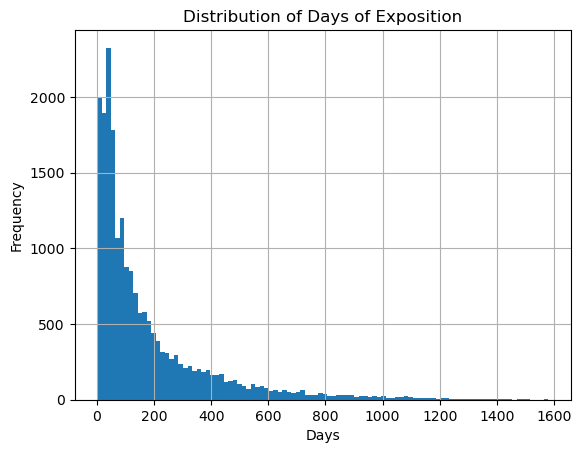

In [63]:
data['days_exposition'].hist(bins=100)
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Distribution of Days of Exposition')
plt.show()

The average time for a property to sell is 95 days.
Sales that take less than 45 days can be considered fast.
Sales that take more than 232 days are unusually long.

## Which Factors Most Affect the Total Price of a Property?

Let's assess the features based on the correlation coefficient and scatter plot.

### Total Area

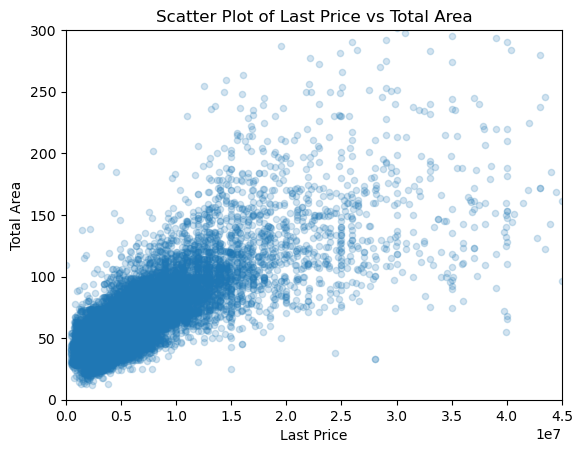

In [64]:
data.plot(x='last_price', y='total_area', kind='scatter', ylim=(0, 300), xlim=(0, 45000000), alpha=.2)
plt.xlabel('Last Price')
plt.ylabel('Total Area')
plt.title('Scatter Plot of Last Price vs Total Area')
plt.show()

The Pearson coefficient of 0.65 and the scatter plot indicate a positive correlation between the total area of the property and its price.

### Living Area

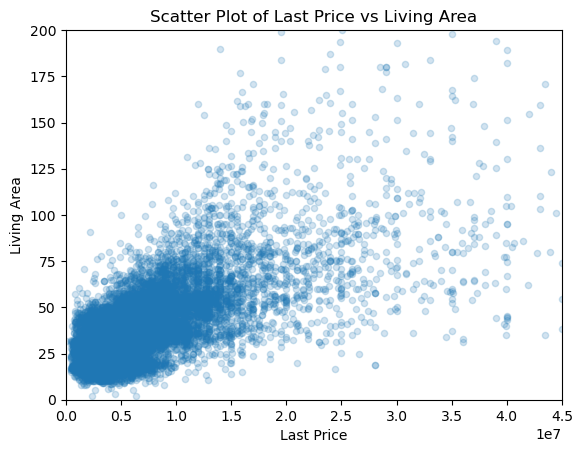

In [65]:
data.plot(x='last_price', y='living_area', kind='scatter', ylim=(0, 200), xlim=(0, 45000000), alpha=.2)
plt.xlabel('Last Price')
plt.ylabel('Living Area')
plt.title('Scatter Plot of Last Price vs Living Area')
plt.show()

There is a positive correlation between the living area of the property and its price. The Pearson coefficient is 0.58, slightly lower than the correlation between the total area and the price.

### Kitchen Area

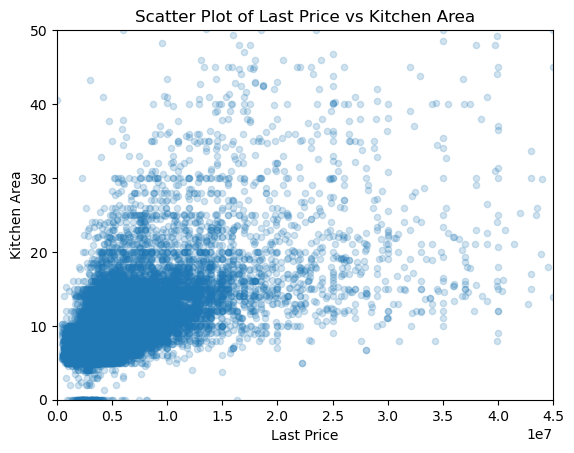

In [66]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', ylim=(0, 50), xlim=(0, 45000000), alpha=.2)
plt.xlabel('Last Price')
plt.ylabel('Kitchen Area')
plt.title('Scatter Plot of Last Price vs Kitchen Area')
plt.show()

There is also a positive correlation between the kitchen area and the price of the property. The Pearson coefficient is 0.49, which is lower than the coefficients for the total area and the living area.

### Number of Rooms

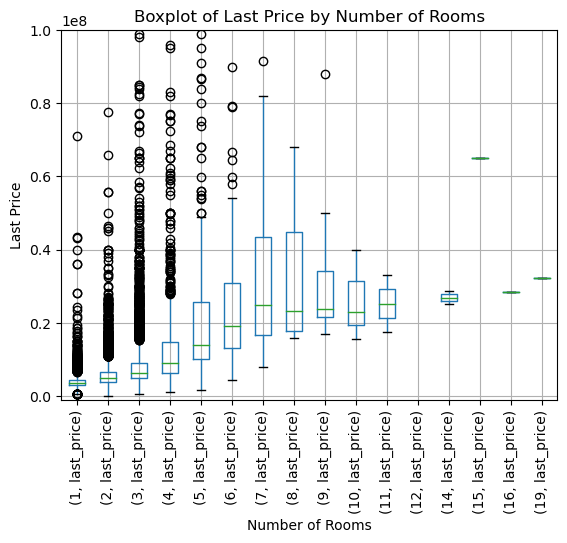

In [67]:
data1 = data.groupby('rooms')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False, rot=90).set_ylim(-1000000, 100000000)
plt.xlabel('Number of Rooms')
plt.ylabel('Last Price')
plt.title('Boxplot of Last Price by Number of Rooms')
plt.show()

The price of the property depends on the number of rooms. There is a direct correlation from 1 to 8 rooms, and for more than 8 rooms, there is a slight decline in prices.

### Floor Type

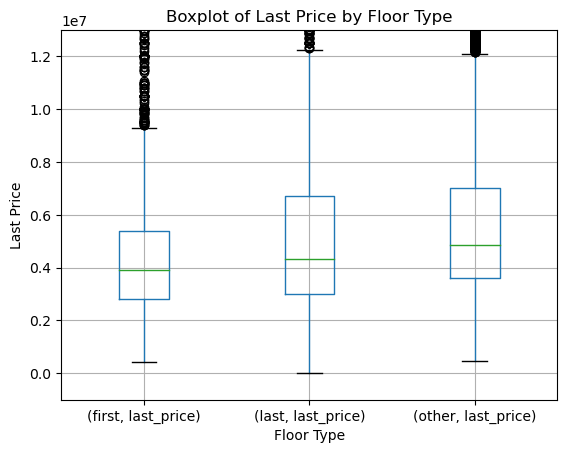

In [68]:
data1 = data.groupby('floor_type')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False).set_ylim(-1000000, 13000000)
plt.xlabel('Floor Type')
plt.ylabel('Last Price')
plt.title('Boxplot of Last Price by Floor Type')
plt.show()

In terms of floor type, prices of properties are arranged in the following order: first floors, last floors, and others.

### Publication Date

#### Day of the Week

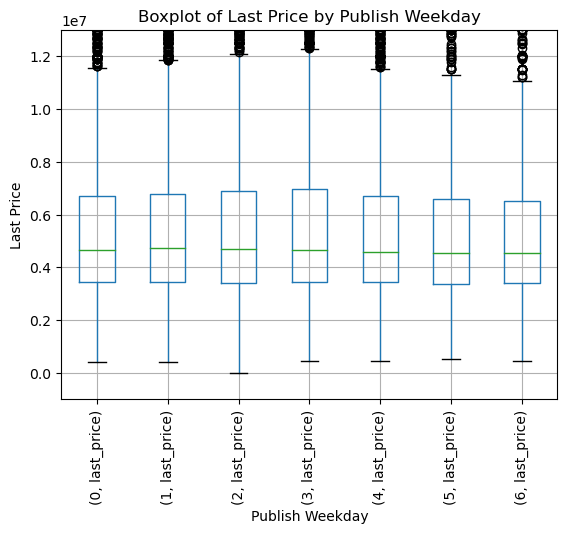

In [69]:
data1 = data.groupby('publish_weekday')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False, rot=90).set_ylim(-1000000, 13000000)
plt.xlabel('Publish Weekday')
plt.ylabel('Last Price')
plt.title('Boxplot of Last Price by Publish Weekday')
plt.show()

By the middle of the week, the prices for ads are slightly higher than at the beginning and on weekends.
This can be attributed to the fact that sellers of more expensive real estate often turn to real estate agents, who often include their fees in the price of the property. These agents do not work on weekends, while sellers of cheaper properties post ads themselves, including on weekends.

#### Month

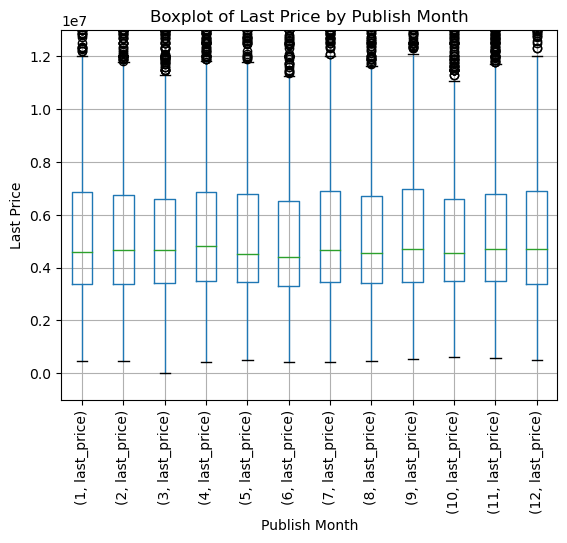

In [70]:
data1 = data.groupby('publish_month')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False, rot=90).set_ylim(-1000000, 13000000)
plt.xlabel('Publish Month')
plt.ylabel('Last Price')
plt.title('Boxplot of Last Price by Publish Month')
plt.show()

Prices vary from month to month, but no specific patterns were identified.

#### Year

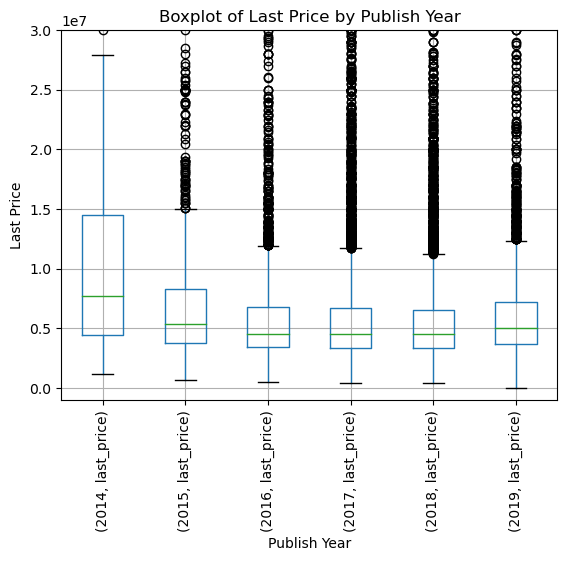

In [71]:
data1 = data.groupby('publish_year')
fig, ax = plt.subplots()
data1.boxplot(ax=ax, column=['last_price'], subplots=False, rot=90).set_ylim(-1000000, 30000000)
plt.xlabel('Publish Year')
plt.ylabel('Last Price')
plt.title('Boxplot of Last Price by Publish Year')
plt.show()

After 2014, property prices decreased for two years and then stabilized.

The price of a property is influenced by the following parameters:
- total area;
- living area;
- kitchen area;
- number of rooms;
- floor type.

There is also a correlation between the price and the year of ad publication. A slight correlation is observed between the price and the day of the week. No correlation was found between the price and the month.

## Cities with the Highest and Lowest Price per Square Meter

In [72]:
top_cities_list = (data.groupby('locality_name').count().sort_values(by='total_area', ascending=False).index[:10])
print('Top 10 cities with the highest number of listings:')
[print(i) for i in top_cities_list];

Top 10 cities with the highest number of listings:
Saint petersburg
Murino
Kudrovo
Shushary
Vsevolozhsk
Pushkin
Kolpino
Pargolovo
Gatchina
Vyborg


In [73]:
cities_and_prices = {}
for i in top_cities_list:
    price = data.query('locality_name == @i')['last_price'].mean()
    area = data.query('locality_name == @i')['total_area'].mean()
    cities_and_prices[price/area] = i

min_price = min(list(cities_and_prices.keys()))
max_price = max(list(cities_and_prices.keys()))

print(f"Minimum price per square meter in the city of {cities_and_prices[min_price]}: {min_price}")
print(f"Maximum price per square meter in the city of {cities_and_prices[max_price]}: {max_price}")

Minimum price per square meter in the city of Vyborg: 57898.14210869611
Maximum price per square meter in the city of Saint petersburg: 124514.62137809927


Among the top 10 cities with the highest number of ads, the lowest price per square meter is in Vyborg, while the highest is in St. Petersburg.

## Correlation between Property Price and Distance to the City Center

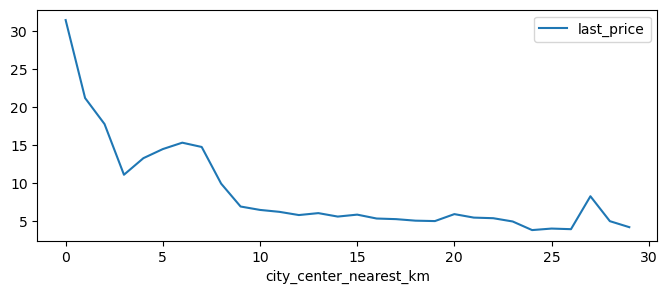

In [74]:
max_dist = data.query('locality_name == "Saint petersburg"')['city_center_nearest_km'].max()
km_to_price = data.query('locality_name == "Saint petersburg"').pivot_table(
    index='city_center_nearest_km', 
    values='last_price', 
    aggfunc=('mean')
)/1000000

km_to_price.plot(figsize=(8, 3));

In [75]:
km_to_price

,last_price
city_center_nearest_km,
0,31.449116
1,21.206721
2,17.788320
3,11.126581
4,13.304280
5,14.499121
6,15.338418
7,14.775153
8,9.957717


There is a dependence between the distance to the city center and the price of the property.
The closer the property is to the city center, the more expensive it is.

## Overall Conclusion

In the initial stage, the data were quickly reviewed, and further actions for data preprocessing were evaluated.
During the data preprocessing stage, the following operations were performed on the data:
- data type conversion;
- identification and removal of duplicates;
- filling in missing values;
- correction and interpretation of anomalous data.

New columns with calculated data were added, which were subsequently used in the analysis.
During the exploratory data analysis stage, the main parameters of the properties and the time it took to sell them were examined and interpreted.

In the next and final stage, dependencies between various property parameters and their prices were discovered. The correlation between the property prices and the distance to the city center was also examined.
The most significant finding is the correlation between the price and the following parameters: total area, living area, kitchen area, number of rooms, and distance to the city center.

The results of this work can be useful for assessing deviations in property prices from the market average, evaluating new properties, and developing a recommendation system for property valuation.